Importing Libraries
For data handling pandas and numpy, for visualization matplotlib and seaborn, and for models and other workings scikit-learn, XGBoost and LightGBM

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

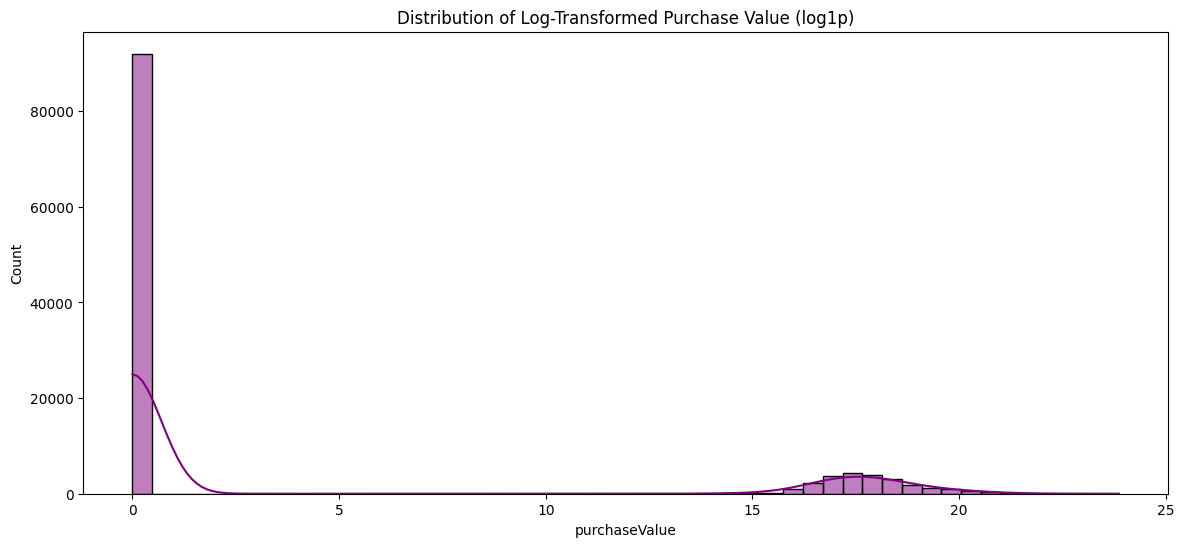

In [2]:
train_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

plt.figure(figsize=(14, 6))
sns.histplot(np.log1p(train_df['purchaseValue'].fillna(0)), bins=50, kde=True, color='purple')
plt.title('Distribution of Log-Transformed Purchase Value (log1p)')
plt.show()

Visualization 1: Distribution of Purchase Value
This histogram shows that the log-transformed purchase value is more evenly distributed.

Descriptive stats of data is presented below

In [3]:
print("Training data info:")
train_df.info()
train_df.describe()

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding 

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


Visualization 2: Missing Values
This bar chart shows the percentage of missing data in each column.

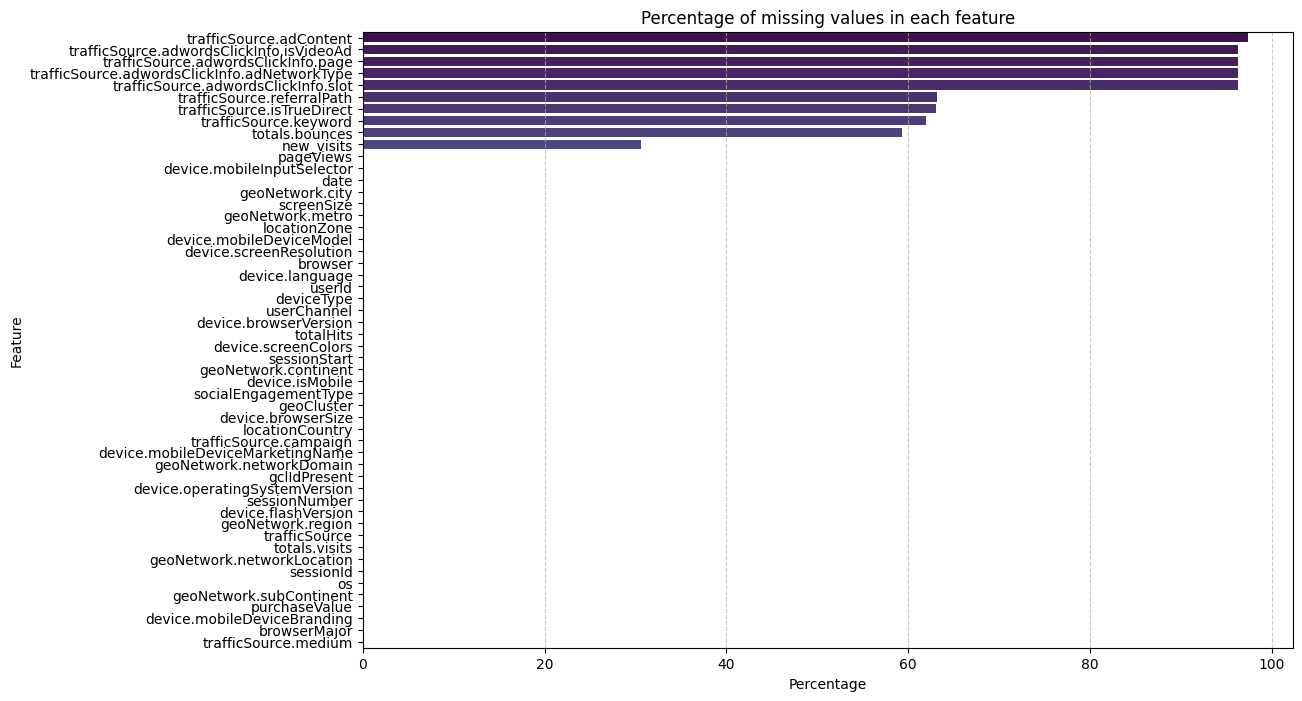

In [4]:
# Missing values
missing_values = train_df.isnull().sum() / len(train_df) * 100
missing_df = missing_values.sort_values(ascending=False).reset_index()
missing_df.columns = ['Feature', 'Percentage']

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Percentage', y='Feature', data=missing_df, palette='viridis')
plt.title('Percentage of missing values in each feature')
plt.xlabel('Percentage')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Visualization 3: Correlation Heatmap
#The heatmap shows the correlation between numerical features

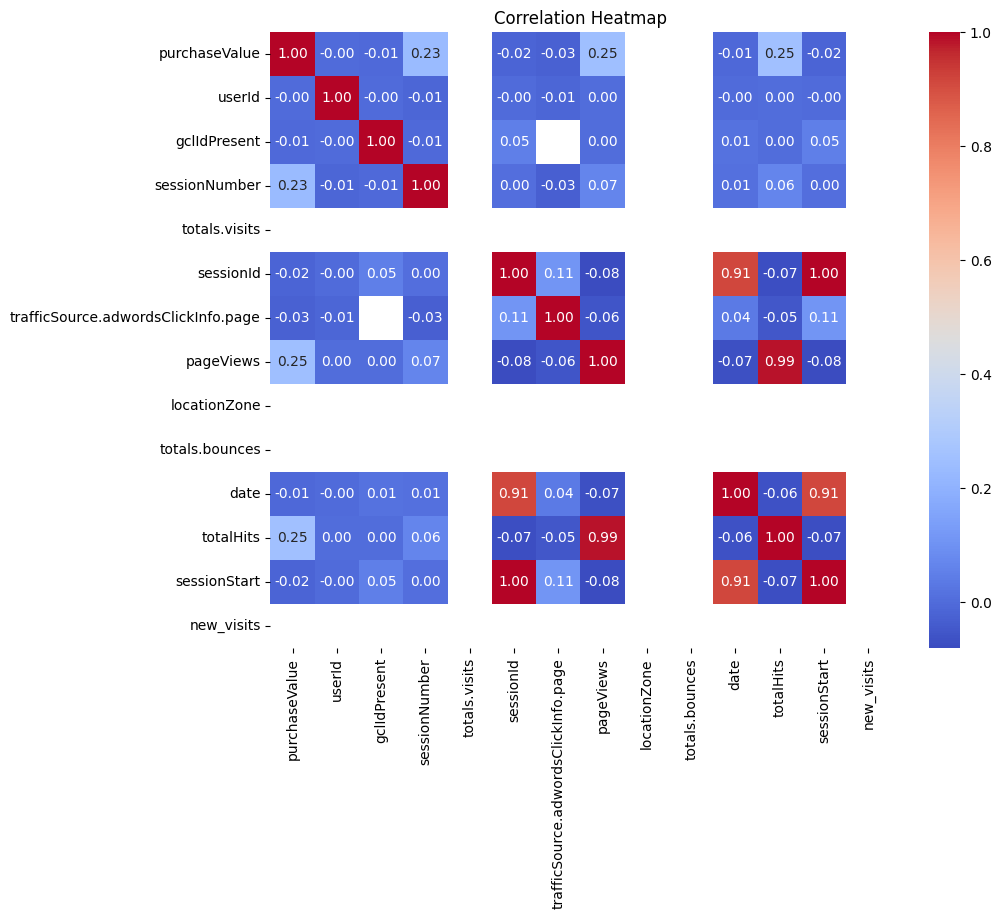

In [5]:
# Correlation matrix
plt.figure(figsize=(10, 8))
numerical_cols = train_df.select_dtypes(include=np.number).columns
correlation_matrix = train_df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

Plotting distributions for the following categorical columns


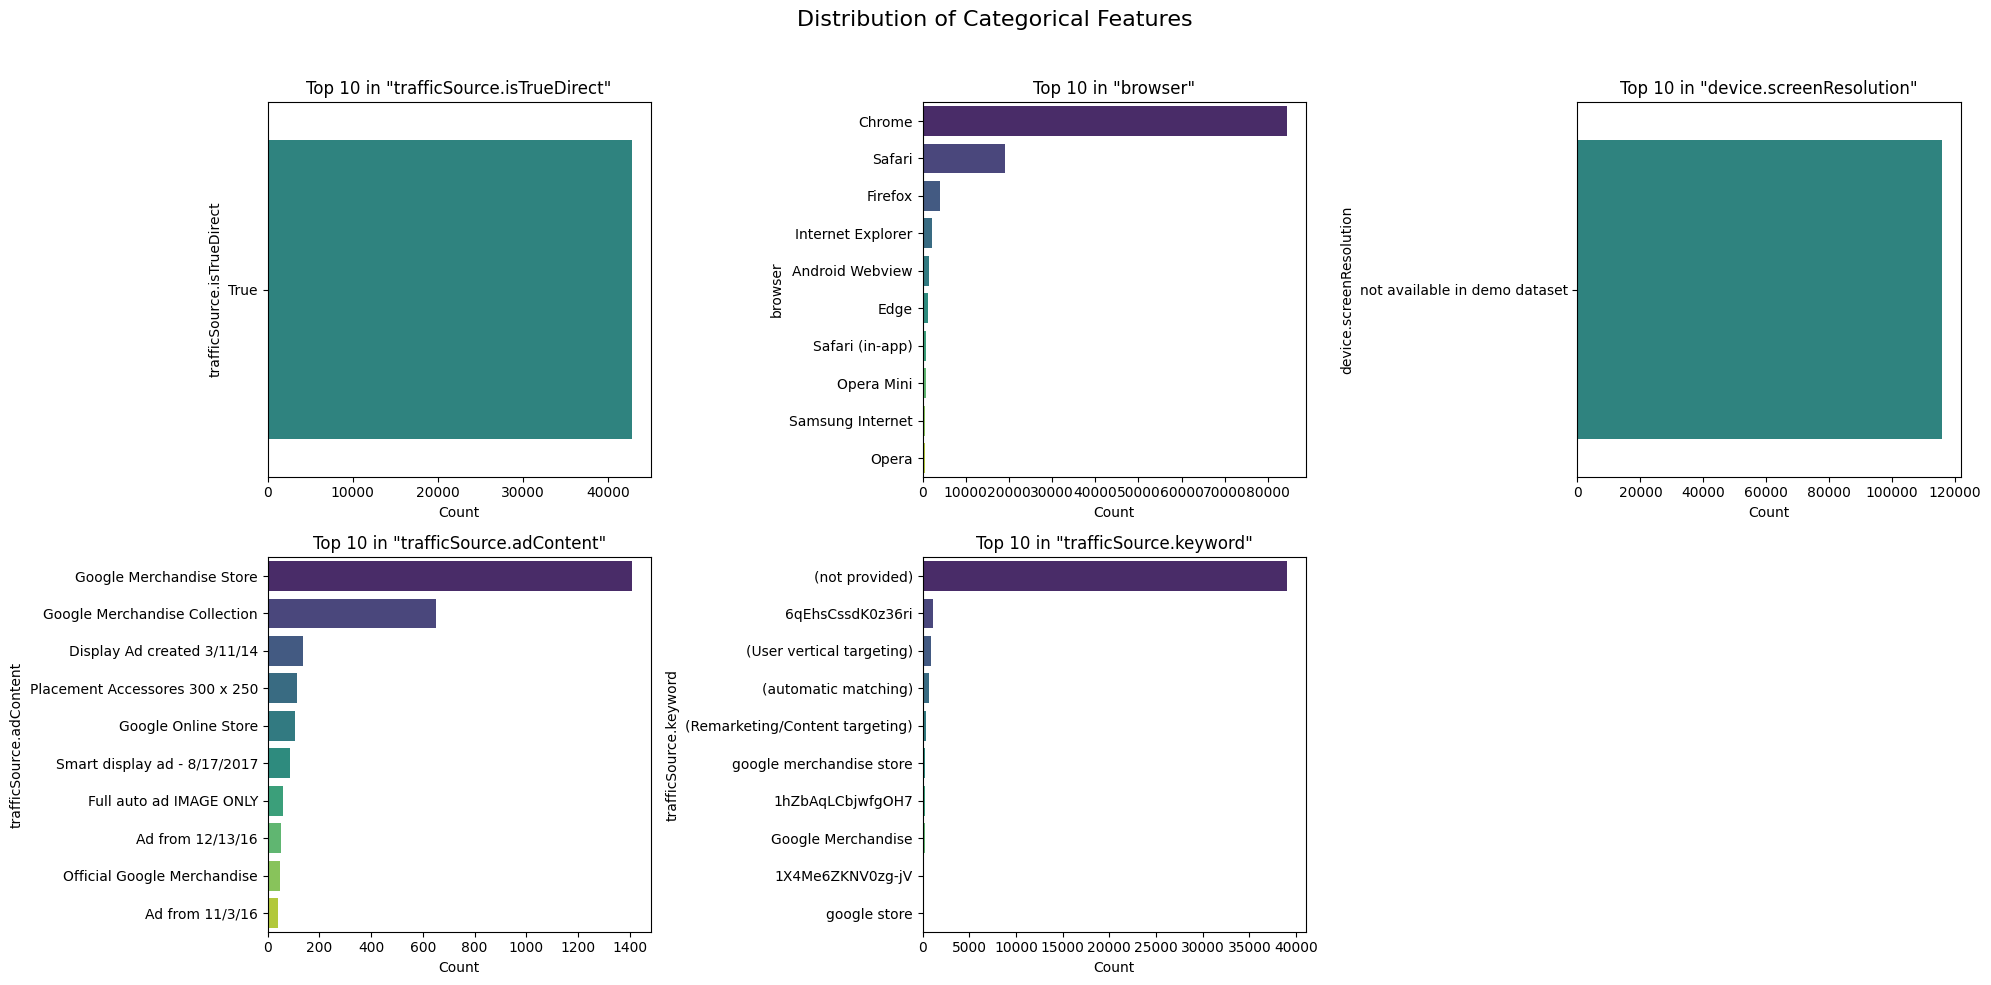

In [6]:
# identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category', 'bool']).columns
cols_to_plot = categorical_cols[:5] 

print("Plotting distributions for the following categorical columns")

n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

fig.suptitle('Distribution of Categorical Features', fontsize=16)

for i, col in enumerate(cols_to_plot):
    top_10_cats = train_df[col].value_counts().nlargest(10).index
    
    sns.countplot(ax=axes[i], y=train_df[col], order=top_10_cats, palette='viridis')
    axes[i].set_title(f'Top 10 in "{col}"')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col)
for i in range(len(cols_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Plotting Purchase Value across the following categorical columns


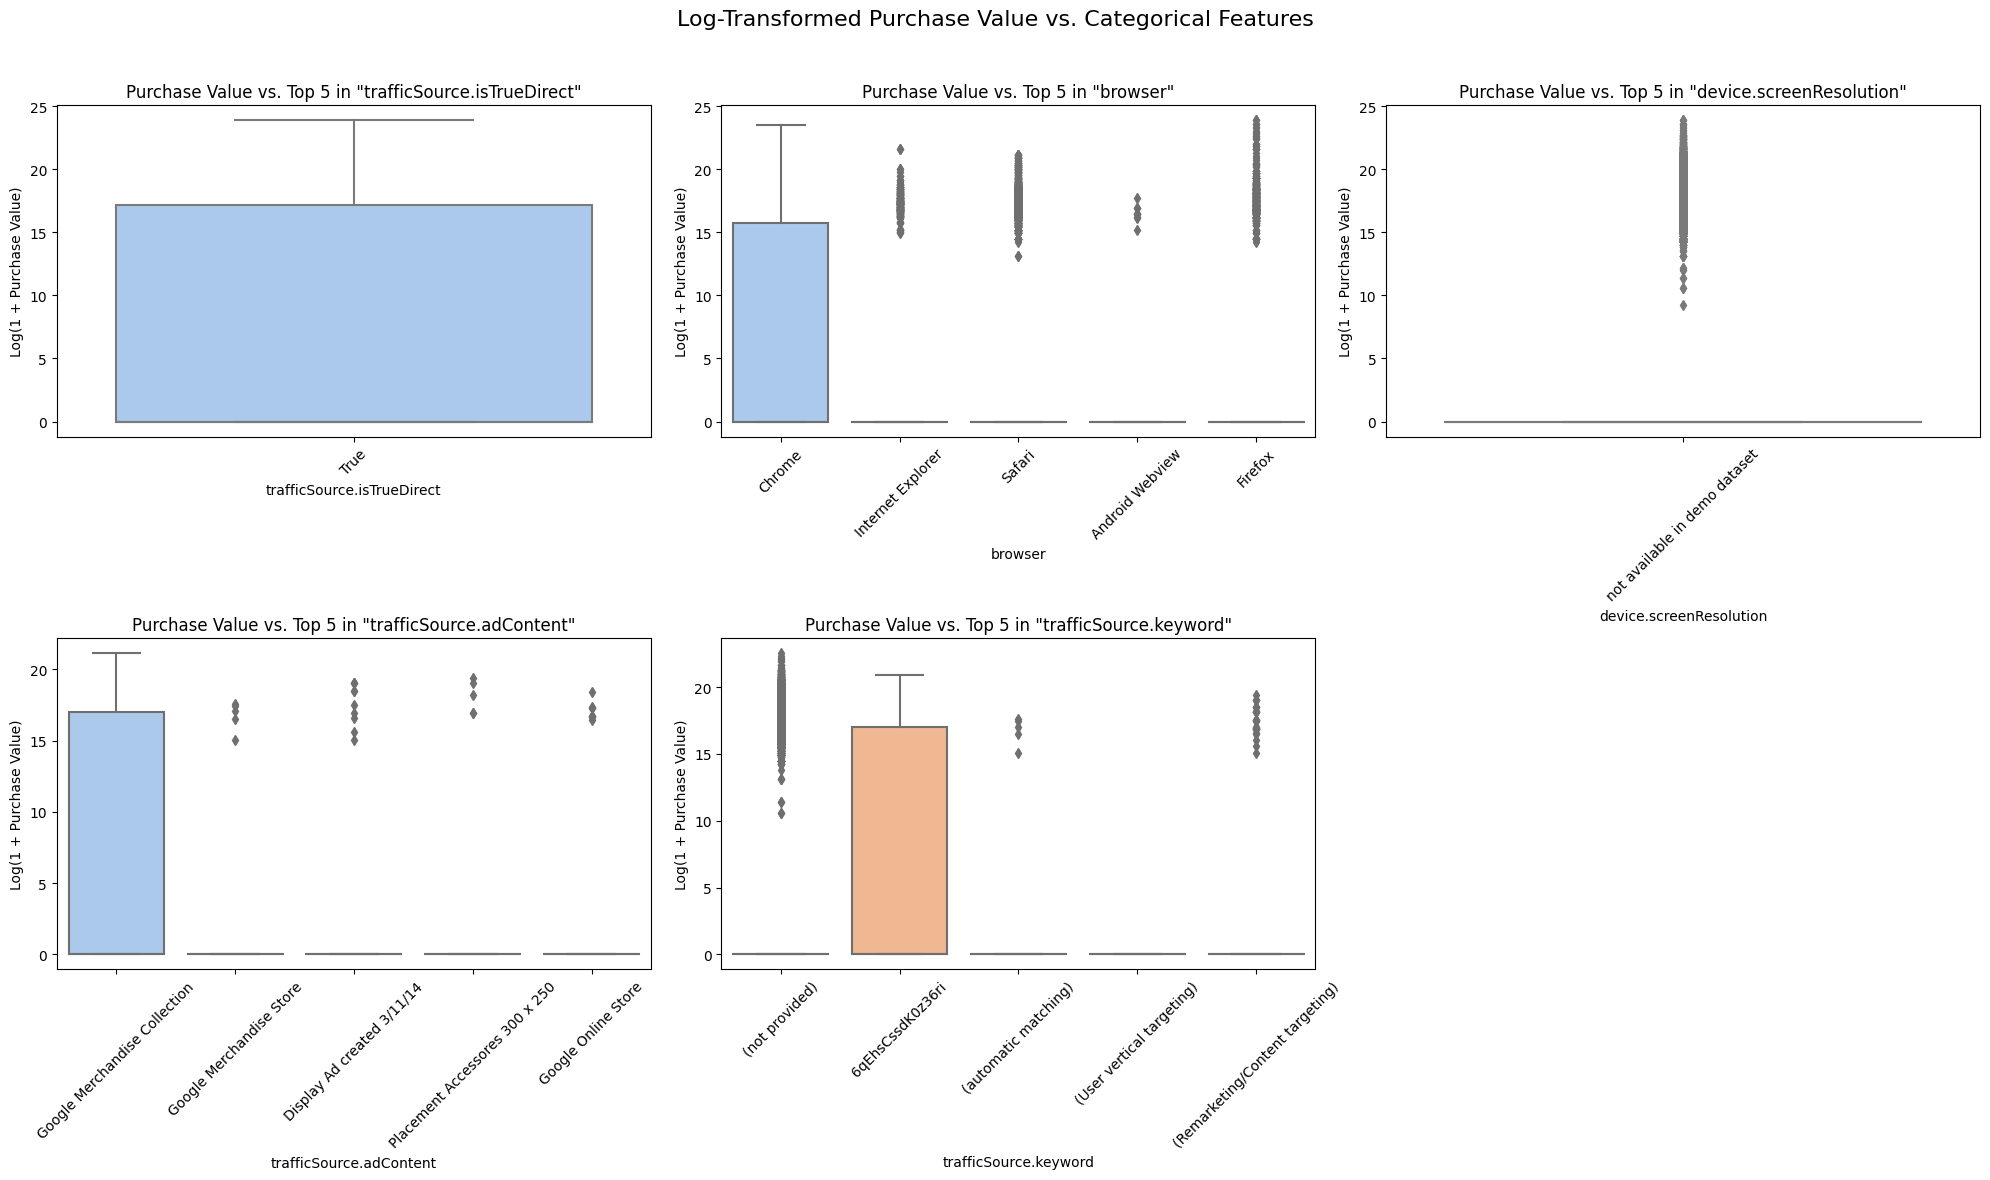

In [7]:
print("Plotting Purchase Value across the following categorical columns")

train_df['logPurchaseValue'] = np.log1p(train_df['purchaseValue'])
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

fig.suptitle('Log-Transformed Purchase Value vs. Categorical Features', fontsize=16)

for i, col in enumerate(cols_to_plot):
    top_5_cats = train_df[col].value_counts().nlargest(5).index
    df_filtered = train_df[train_df[col].isin(top_5_cats)]
    sns.boxplot(ax=axes[i], x=col, y='logPurchaseValue', data=df_filtered, palette='pastel')
    axes[i].set_title(f'Purchase Value vs. Top 5 in "{col}"')
    axes[i].set_ylabel('Log(1 + Purchase Value)')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

for i in range(len(cols_to_plot), len(axes)):
    axes[i].set_visible(False)

train_df = train_df.drop(columns=['logPurchaseValue'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Imputation**: Missing numerical data is filled with the median, and categorical data is filled with the word 'missing'.
**Encoding**: Categorical text data is converted into numerical labels.
**Scaling**: Numerical features are scaled using `RobustScaler`, which is good at handling outliers.

In [8]:
# Combine train and test
combined = pd.concat([train_df, test_df], keys=['train', 'test'])

# Identify numeric and categorical column
num_cols = combined.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = combined.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Impute numeric columns with the median value
num_imputer = SimpleImputer(strategy='median')
combined[num_cols] = num_imputer.fit_transform(combined[num_cols])

# Impute categorical columns with a constant
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
combined[cat_cols] = cat_imputer.fit_transform(combined[cat_cols])

# LabelEncoder
for col in cat_cols:
    encoder = LabelEncoder()
    combined[col] = encoder.fit_transform(combined[col].astype(str))

# Split the combined data back into train and test
train_processed = combined.xs('train')
test_processed = combined.xs('test')

num_cols_for_scaling = [c for c in num_cols if c != 'purchaseValue']

# Scaling
scaler = RobustScaler()
scaler.fit(train_processed[num_cols_for_scaling])
train_processed[num_cols_for_scaling] = scaler.transform(train_processed[num_cols_for_scaling])
test_processed[num_cols_for_scaling] = scaler.transform(test_processed[num_cols_for_scaling])

X = train_processed.drop(columns=["purchaseValue"])
y = train_processed["purchaseValue"]

In [9]:
# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = train_processed.drop(columns=["purchaseValue"])
y_train = train_processed["purchaseValue"]

# Models
models = {
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1)
}
performance_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    r2 = r2_score(y_val, predictions)
    performance_scores[name] = r2
    print(f"{name} Validation R2 score: {r2:.4f}")

best_model_name = max(performance_scores, key=performance_scores.get)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 116023, number of used features: 32
[LightGBM] [Info] Start training from score 26563930.071796
LightGBM Validation R2 score: 0.4950
RandomForest Validation R2 score: 0.8927
XGBoost Validation R2 score: 0.8556


In [10]:
print(f"\n ({best_model_name}) model is used for submission ")

final_model = models[best_model_name]

# Example of Hyperparameter Tuning (HPT) using RandomizedSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }
# random_search = RandomizedSearchCV(
#     estimator=final_model,
#     param_distributions=param_dist,
#     n_iter=10,  # Number of parameter settings that are sampled
#     cv=3,       # 3-fold cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )
#
# random_search.fit(X, y)
# final_model = random_search.best_estimator_

final_model.fit(X, y)

X_test = test_processed.drop(columns=['purchaseValue'], errors='ignore')
X_test = X_test[X.columns] 

# Final prediction
final_predictions = final_model.predict(X_test)
final_predictions[final_predictions < 0] = 0

# Submission
submission_df = pd.DataFrame({
    'id': np.arange(len(final_predictions)),
    'purchaseValue': final_predictions
})
submission_df.to_csv('submission.csv', index=False)

print("submission done")


 (RandomForest) model is used for submission 
submission done
